This notebook is to make the final version of Figure 2, which has the MDS plot and the between patient same-site beta diversities.

I copied this from 2018-01-02.pca_and_between_patient_div_final.ipynb to make the same figures with Bray-Curtis distance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# to pretty print dataframes
from IPython.display import display

plt.style.use('seaborn-white')

In [2]:
# Raw data
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

df = pd.read_csv(fnotu, sep='\t', index_col=0)
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

# Bray Curtis
fnbc = '/Users/claire/github/aspiration-analysis/data/analysis/braycurtis.wide.txt'
bc = pd.read_csv(fnbc, sep='\t', index_col=0)

# Seed random state
random_state = 212345

In [3]:
#sns.palplot(sns.color_palette("Set1"))

In [4]:
# Prepare colors
pal = sns.color_palette("Set1")

sites = ['bal', 'throat_swab', 'gastric_fluid', 'stool']
colors = [pal[1], pal[2], pal[0], pal[4]]
colordict = {i: k for i, k in zip(sites, colors)}


## PCoA for 2014 and 2016 batches

We'll make the PCoA plots for each batch separately (otherwise, you can see the different batches).

### 2016 batch

The 2016 batch has the stool samples, so this will be the one in the paper. Let's plot this one first:

In [5]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2016')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

In [6]:
# Make sure all patients only have one sample per site represented here
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
tmp[tmp > 1]

Series([], dtype: int64)

('bal', 21)
('throat_swab', 52)
('gastric_fluid', 43)
('stool', 14)


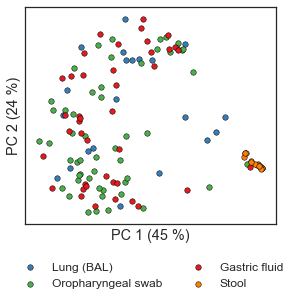

In [9]:
# Prepare for plotting
sns.set_style('white')
labels = {'gastric_fluid': 'Gastric fluid',
          'throat_swab': 'Oropharyngeal swab',
          'bal': 'Lung (BAL)',
          'stool': 'Stool'}

## Do PCA
pca2016 = PCA(random_state=random_state)\
    .fit(bc.loc[keep_batch, keep_batch].values)

Y2016 = pca2016.transform(bc.loc[keep_batch, keep_batch].values)

# Put PC's in a df and add metadata
df2016 = pd.DataFrame(Y2016, index=keep_batch, columns=range(0, Y2016.shape[1]))
df2016 = df2016.join(meta[['site', 'batch']])

## Plot

# Set up figure
fig, ax = plt.subplots(figsize=(4.5,4))

# Plot each site
for site in sites:
    subdf = df2016.query('site == @site')
    print(site, subdf.shape[0])
    ax.scatter(subdf.iloc[:, 0], subdf.iloc[:, 1], 
                c=colordict[site], 
                label=labels[site],
                s=30, linewidths=0.5, edgecolor='k')

## Figure annotations/labels
# Legend
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
                ncol=2, fontsize='large')

# X and Y labels
ax.set_xlabel(
    'PC 1 ({:.0f} %)'.format(pca2016.explained_variance_ratio_[0]*100),
    fontsize='x-large')
ax.set_ylabel(
    'PC 2 ({:.0f} %)'.format(pca2016.explained_variance_ratio_[1]*100),
    fontsize='x-large')

# Get rid of x and y ticks (I think this is ok, right?)
ax.set_xticks([])
ax.set_yticks([])

#plt.title('PCoA', fontsize='x-large')
#txt = ax.text(-0.11, 1.025, 'A', transform=ax.transAxes, fontsize=24)

fig.savefig('../../final/figures/suppfig.pcoa.braycurtis.png', 
            bbox_extra_artists=(lgd, ), bbox_inches='tight',
            dpi=200)

### Patients in 2016 PCoA

In [10]:
samples = keep_batch
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site', 'mbs_consolidated'])\
    .size()

site           mbs_consolidated      
bal            Aspiration/Penetration    13
               Normal                     6
               nan                        2
gastric_fluid  Aspiration/Penetration    18
               Normal                    11
               nan                       14
stool          nan                       14
throat_swab    Aspiration/Penetration    17
               Normal                     7
               nan                       28
dtype: int64

In [11]:
meta\
    .loc[samples, ['subject_id', 'mbs_consolidated', 'site']]\
    .drop_duplicates()\
    .fillna('nan')\
    .groupby(['site'])\
    .size()

site
bal              21
gastric_fluid    43
stool            14
throat_swab      52
dtype: int64

## 2014 samples, PCA

('bal', 81)
('throat_swab', 124)
('gastric_fluid', 104)
('stool', 11)


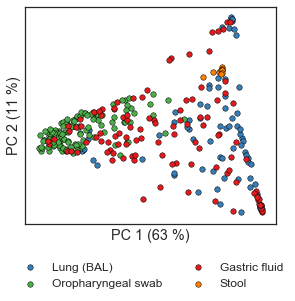

In [12]:
#from sklearn.manifold import MDS

## PCA on the 2014 samples
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2014')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

## Do PCA
pca2014 = PCA(random_state=random_state)\
    .fit(bc.loc[keep_batch, keep_batch].values)

Y2014 = pca2014.transform(bc.loc[keep_batch, keep_batch].values)
#Y2014 = MDS().fit_transform(jsd.loc[keep_batch, keep_batch].values)

# Put PC's in a df and add metadata
df2014 = pd.DataFrame(Y2014, index=keep_batch, columns=range(0, Y2014.shape[1]))
df2014 = df2014.join(meta[['site', 'batch']])

## Plot

# Set up figure
fig, ax = plt.subplots(figsize=(4.5,4))

# Plot each site
for site in sites:
    subdf = df2014.query('site == @site')
    print(site, subdf.shape[0])
    ax.scatter(subdf.iloc[:, 0], subdf.iloc[:, 1], 
                c=colordict[site], 
                label=labels[site],
                s=30, linewidths=0.5, edgecolor='k')
## Figure annotations/labels
# Legend
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
                ncol=2, fontsize='large')

# X and Y labels
ax.set_xlabel(
    'PC 1 ({:.0f} %)'.format(pca2014.explained_variance_ratio_[0]*100),
    fontsize='x-large')
ax.set_ylabel(
    'PC 2 ({:.0f} %)'.format(pca2014.explained_variance_ratio_[1]*100),
    fontsize='x-large')

# Get rid of x and y ticks (I think this is ok, right?)
ax.set_xticks([])
ax.set_yticks([])

#plt.title('PCoA', fontsize='x-large')
#txt = ax.text(-0.11, 1.025, 'B', transform=ax.transAxes, fontsize=24)

fig.savefig('../../final/figures/suppfig.pcoa_2014_batch.braycurtis.png', 
            bbox_extra_artists=(lgd, ), bbox_inches='tight',
            dpi=200)

# Across-patient beta diversity

Now, let's make the other part of this figure: the across-patient beta diversity (between same sites across different patients.)

Here, we'll plot results from both batches together, while ensuring that we only keep within-batch comparisons.

In [13]:
# For these plots, I'll need to select just the within-sequencing batch comparisons
# in addition to making sure there are no duplicate samples from the same patient

In [15]:
fnbclong = '../../data/analysis/braycurtis.txt'
bclong = pd.read_csv(fnbclong, sep='\t')
bclong.head()

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,18,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,...,percent distal acid,percent proximal acid,percent proximal nonacid,percent distal total,number of full colum events/total events,Number of full column episodes,Was Bile CA detected?,Was Bile DCA detected?,Was Bile LCA detected?,Was Bile TCA detected?
0,01-112-7GI,01-112-7RI,0.382969,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-112-7GI,01-112-7TI,0.994299,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-112-7RI,01-112-7TI,0.989603,rectal_swab,throat_swab,rectal_swab-throat_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-112-7GI,01-164-7GI,0.994963,gastric_fluid,gastric_fluid,gastric_fluid-gastric_fluid,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-112-7RI,01-164-7GI,0.990890,rectal_swab,gastric_fluid,rectal_swab-gastric_fluid,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Keep just the "between" patient comparisons
btw_bc = bclong.query('patient_comp == "between"')

# Keep just aerodigestive site comparisons
keep_comps = ['bal-bal', 'throat_swab-throat_swab', 'gastric_fluid-gastric_fluid']
btw_bc = btw_bc.query('site_comparison == @keep_comps')

btw_bc.fillna('nan').groupby(['site_comparison', 'batch1', 'batch2']).size()

site_comparison              batch1  batch2
bal-bal                      2014    2014      3240
                                     2016      1364
                             2016    2014       337
                                     2016       210
gastric_fluid-gastric_fluid  2014    2014      5356
                                     2016      2827
                             2016    2014      1645
                                     2016       903
throat_swab-throat_swab      2014    2014      7626
                                     2016      3648
                             2016    2014      2800
                                     2016      1326
dtype: int64

In [17]:
bc2014 = btw_bc.query('(batch1 == 2014) & (batch2 == 2014)')
bc2016 = btw_bc.query('(batch1 == 2016) & (batch2 == 2016)')

bcboth = pd.concat((bc2014, bc2016))

/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


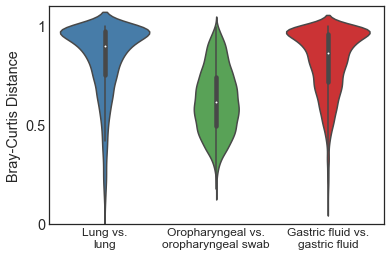

In [18]:
order_fig = ['bal-bal', 'throat_swab-throat_swab', 'gastric_fluid-gastric_fluid']

# Prepare colors
pal = sns.color_palette("Set1")
colors = [pal[1], pal[2], pal[0]]
colordict = {i: k for i, k in zip(order_fig, colors)}

fig, ax = plt.subplots()
sns.violinplot(data=bcboth, x='site_comparison', y='beta', 
               inner='box', order=order_fig,
               palette=colordict)


ax.set_xlabel('')
ax.set_xticklabels(['Lung vs.\nlung', 
                    'Oropharyngeal vs.\noropharyngeal swab',
                    'Gastric fluid vs.\ngastric fluid'],
                  fontsize='large')
ax.set_ylim([0, 1.1])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1], fontsize='x-large')
ax.set_ylabel('Bray-Curtis Distance', fontsize='x-large')

#ax.text(-0.11, 1.025, 'B', transform=ax.transAxes, fontsize=24)

#ax.set_title('Across patient beta diversity', fontsize='xx-large')
fig.savefig('../../final/figures/suppfig.across_patient_beta_div_same_site.braycurtis.png', dpi=200)

## Sample size

Next, we'll print out some information about the number of samples in each comparison and the mean, std, median, etc JSD for each comparison type:

In [19]:
bcboth.groupby('site_comparison')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
site_comparison,,,,,,,,
bal-bal,3450.0,0.832811,0.183172,0.055494,0.751418,0.900398,0.973391,0.999647
gastric_fluid-gastric_fluid,6259.0,0.819976,0.161520,0.097078,0.715323,0.864927,0.956862,0.999551
throat_swab-throat_swab,8952.0,0.622682,0.162727,0.175042,0.496196,0.614900,0.742480,0.994740


# PERMANOVA and ANOSIM

Calculate PERMANOVA statistics within each sequencing batch.

In [20]:
from skbio.stats.distance import permanova, anosim
from skbio.stats.distance import DistanceMatrix

In [21]:
sites = ['bal', 'throat_swab', 'gastric_fluid']

## 2016 samples

In [22]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2016')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

# Check that no patient has duplicate sites
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
print(tmp[tmp > 1])

bc2016 = bc.loc[keep_batch, keep_batch]


Series([], dtype: int64)


In [24]:
dm = DistanceMatrix(bc2016.values, ids=bc2016.index)
permanova(dm, meta.loc[bc2016.index, 'site'], permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     116
number of groups                  3
test statistic              2.15592
p-value                      0.0026
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [25]:
anosim(dm, meta.loc[bc2016.index, 'site'], permutations=9999)

method name                  ANOSIM
test statistic name               R
sample size                     116
number of groups                  3
test statistic            0.0634696
p-value                      0.0107
number of permutations         9999
Name: ANOSIM results, dtype: object

## 2014 samples

In [26]:
# Get samples from the 4 sites of interest and in 2016 batch
keep_batch = meta\
    .query('site == @sites')\
    .query('batch == 2014')\
    .index

# Get rid of any "F" samples (these are second time points samples)
# There is also one patient with duplicate throat and stool samples taht end in 'sick'
keep_batch = [i for i in keep_batch 
              if not i.endswith('F') 
              and not i.endswith('sick') 
              and not i.endswith('F2') 
              and not i.endswith('F2T')
              and not i.startswith('05')]

# Check that no patient has duplicate sites
tmp = meta.loc[keep_batch].groupby(['subject_id', 'site']).size()
print(tmp[tmp > 1])

bc2014 = bc.loc[keep_batch, keep_batch]

Series([], dtype: int64)


In [27]:
dm = DistanceMatrix(bc2014.values, ids=bc2014.index)
permanova(dm, meta.loc[bc2014.index, 'site'], permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     309
number of groups                  3
test statistic              29.6098
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [28]:
anosim(dm, meta.loc[bc2014.index, 'site'], permutations=9999)

method name                 ANOSIM
test statistic name              R
sample size                    309
number of groups                 3
test statistic            0.430092
p-value                     0.0001
number of permutations        9999
Name: ANOSIM results, dtype: object